In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Import libraries and fixing the random state to 42 for entire notebook

#Set the seed value
seed_value=15042

#Set the seed as a local environment variable
import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

import warnings
warnings.filterwarnings('ignore')
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PolynomialFeatures,RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet, LogisticRegression
from sklearn.linear_model import LassoCV,RidgeCV,ElasticNetCV
from sklearn.feature_selection import RFE, VarianceThreshold
from sklearn.model_selection import GridSearchCV,KFold,RandomizedSearchCV, StratifiedKFold,cross_val_score
from sklearn.metrics import r2_score
sns.set_context("paper", font_scale = 1, rc={"grid.linewidth": 3})
pd.set_option('display.max_rows', 100, 'display.max_columns', 400)
from scipy.stats import skew,boxcox_normmax
from scipy.special import boxcox1p
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, f1_score
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRFRegressor, XGBRFClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from mlxtend.regressor import StackingCVRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, AdaBoostClassifier 

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/Datasets/Finance/train_Data.csv",parse_dates=['DisbursalDate','MaturityDAte','AuthDate'])

df_test = pd.read_csv("/content/drive/MyDrive/Datasets/Finance/test_Data.csv",parse_dates=['DisbursalDate','MaturityDAte','AuthDate'])


types = {"ID":"int32","WRITE-OFF-AMT":"float32","TENURE":"float16"}
df_train_bureau = pd.read_csv("/content/drive/MyDrive/Datasets/Finance/train_bureau.csv",dtype=types,parse_dates=['DATE-REPORTED','DISBURSED-DT','CLOSE-DT','LAST-PAYMENT-DATE'])

types = {"ID":"int32","WRITE-OFF-AMT":"float32","TENURE":"float16"}
df_test_bureau = pd.read_csv("/content/drive/MyDrive/Datasets/Finance/test_bureau.csv",dtype=types,parse_dates=['DATE-REPORTED','DISBURSED-DT','CLOSE-DT','LAST-PAYMENT-DATE'])

In [ ]:
len(df_train)
len(df_test)

14745

In [ ]:
Submission = df_test[['ID']]

#Combining the train and test datasets for better EDA
Y = df_train['Top-up Month']
df_train.drop(['Top-up Month'], axis=1, inplace=True)
df = pd.concat([df_train, df_test],axis=0)
df.shape
df = df.drop_duplicates()

In [ ]:
df.head()

,ID,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Area,Tenure,AssetCost,AmountFinance,DisbursalAmount,EMI,DisbursalDate,MaturityDAte,AuthDate,AssetID,ManufacturerID,SupplierID,LTV,SEX,AGE,MonthlyIncome,City,State,ZiPCODE
0,1,Monthly,Arrear,Closed,PDC_E,1,NaN,48,450000,275000.0,275000.0,24000.0,2012-02-10,2016-01-15,2012-02-10,4022465,1568.0,21946,61.11,M,49.0,35833.33,RAISEN,MADHYA PRADESH,464993.0
1,2,Monthly,Advance,Closed,PDC,333,BHOPAL,47,485000,350000.0,350000.0,10500.0,2012-03-31,2016-02-15,2012-03-31,4681175,1062.0,34802,70.00,M,23.0,666.67,SEHORE,MADHYA PRADESH,466001.0
2,3,Quatrly,Arrear,Active,Direct Debit,1,NaN,68,690000,519728.0,519728.0,38300.0,2017-06-17,2023-02-10,2017-06-17,25328146,1060.0,127335,69.77,M,39.0,45257.00,BHOPAL,MADHYA PRADESH,462030.0
3,7,Monthly,Advance,Closed,Billed,125,GUNA,48,480000,400000.0,400000.0,11600.0,2013-11-29,2017-11-10,2013-11-29,13021591,1060.0,25094,80.92,M,24.0,20833.33,ASHOK NAGAR,MADHYA PRADESH,473335.0
4,8,Monthly,Arrear,Closed,Billed,152,BILASPUR,44,619265,440000.0,440000.0,15000.0,2011-12-08,2015-07-05,2011-12-08,3291320,1046.0,21853,71.05,M,56.0,27313.67,BILASPUR,CHATTISGARH,495442.0


**EDA - Bureau Data**

1. Data-Cleaning
2. Feature Engineering and Feature Selection
(Starting with null value imputation)
3. Encoding and further

In [ ]:
#Dropping duplicates, if any
df_train_bureau = df_train_bureau.drop_duplicates()
df_test_bureau = df_test_bureau.drop_duplicates()

In [ ]:
df_train_bureau.shape, df_test_bureau.shape

((556980, 25), (63331, 25))

In [ ]:
df_train_bureau['Source'] = "Train"
df_test_bureau['Source'] = "Test"
df_bureau_data = pd.concat([df_train_bureau, df_test_bureau],axis=0)
df_bureau_data.shape

(620311, 26)

In [ ]:
df_bureau_data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 620311 entries, 0 to 64018
Data columns (total 26 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   ID                         620311 non-null  int32         
 1   SELF-INDICATOR             620311 non-null  bool          
 2   MATCH-TYPE                 620311 non-null  object        
 3   ACCT-TYPE                  620311 non-null  object        
 4   CONTRIBUTOR-TYPE           620311 non-null  object        
 5   DATE-REPORTED              616634 non-null  datetime64[ns]
 6   OWNERSHIP-IND              620311 non-null  object        
 7   ACCOUNT-STATUS             620311 non-null  object        
 8   DISBURSED-DT               588384 non-null  datetime64[ns]
 9   CLOSE-DT                   340799 non-null  object        
 10  LAST-PAYMENT-DATE          269683 non-null  datetime64[ns]
 11  CREDIT-LIMIT/SANC AMT      16688 non-null   object   

  1. We can see there are 18 variables that are of object dtype and few are of datetime dtype followed by 1 each in float and int category. 
  2. We can also see that there are many variables with missing values. If the percentage of missing values is more than 50%, we will go ahead and delete the variable. 
  3. We also have to check the object variables, about the cardinality. If there are many values, we might have to combine a few of them. 

In [ ]:
df_bureau_data.head()

,ID,SELF-INDICATOR,MATCH-TYPE,ACCT-TYPE,CONTRIBUTOR-TYPE,DATE-REPORTED,OWNERSHIP-IND,ACCOUNT-STATUS,DISBURSED-DT,CLOSE-DT,LAST-PAYMENT-DATE,CREDIT-LIMIT/SANC AMT,DISBURSED-AMT/HIGH CREDIT,INSTALLMENT-AMT,CURRENT-BAL,INSTALLMENT-FREQUENCY,OVERDUE-AMT,WRITE-OFF-AMT,ASSET_CLASS,REPORTED DATE - HIST,DPD - HIST,CUR BAL - HIST,AMT OVERDUE - HIST,AMT PAID - HIST,TENURE,Source
0,1,False,PRIMARY,Overdraft,NAB,2018-04-30,Individual,Delinquent,2015-10-05,NaN,2018-02-27,NaN,"37,352",NaN,"37,873",NaN,"37,873",0.0,Standard,"20180430,20180331,",030000,"37873,12820,","37873,,",",,",NaN,Train
1,1,False,PRIMARY,Auto Loan (Personal),NAB,2019-12-31,Individual,Active,2018-03-19,NaN,2019-12-19,NaN,"44,000","1,405/Monthly","20,797",F03,NaN,0.0,Standard,"20191231,20191130,20191031,20190930,20190831,2...",0000000000000000000000000000000000000000000000...,"20797,21988,23174,24341,25504,26648,27780,2891...",",,,,,,,,,,,,,,,,,,,,1452,,",",,,,,,,,,,,,,,,,,,,,,,",36.0,Train
2,1,True,PRIMARY,Tractor Loan,NBF,2020-01-31,Individual,Active,2019-08-30,NaN,NaT,NaN,"1,45,000",NaN,"1,16,087",NaN,0,0.0,NaN,"20200131,20191231,20191130,20191031,20190930,2...",000000000000000000,"116087,116087,145000,145000,145000,145000,","0,0,0,0,0,0,",",,,,,,",NaN,Train
3,1,True,PRIMARY,Auto Loan (Personal),NBF,2017-09-30,Individual,Closed,2013-09-27,2017-09-21 00:00:00,NaT,NaN,"3,00,000",NaN,0,NaN,0,0.0,NaN,"20170930,20170801,20170731,20170630,20170531,2...",000DDD0270260270260270240270270000320000000000...,"0,,15925,23754,31494,39147,46713,54194,61590,6...","0,,1014,1014,1014,1014,1014,1014,1014,983,0,92...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",NaN,Train
4,1,True,PRIMARY,Tractor Loan,NBF,2016-02-29,Individual,Closed,2012-02-10,2016-02-01 00:00:00,NaT,NaN,"2,75,000",NaN,0,NaN,0,0.0,NaN,"20160229,20160131,20151231,20151130,20151031,2...",0000000000000000000000000000000000000000000000...,"0,0,23658,23321,22989,46321,45662,45012,68030,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",NaN,Train


In [ ]:
(df_bureau_data.isna().sum()/len(df_bureau_data))*100

ID                            0.000000
SELF-INDICATOR                0.000000
MATCH-TYPE                    0.000000
ACCT-TYPE                     0.000000
CONTRIBUTOR-TYPE              0.000000
DATE-REPORTED                 0.592767
OWNERSHIP-IND                 0.000000
ACCOUNT-STATUS                0.000000
DISBURSED-DT                  5.146934
CLOSE-DT                     45.059978
LAST-PAYMENT-DATE            56.524550
CREDIT-LIMIT/SANC AMT        97.309737
DISBURSED-AMT/HIGH CREDIT     0.006126
INSTALLMENT-AMT              75.177613
CURRENT-BAL                   0.042559
INSTALLMENT-FREQUENCY        76.010098
OVERDUE-AMT                  21.128756
WRITE-OFF-AMT                 3.485832
ASSET_CLASS                  53.883294
REPORTED DATE - HIST          3.485832
DPD - HIST                    3.559666
CUR BAL - HIST                3.485832
AMT OVERDUE - HIST            3.485832
AMT PAID - HIST               3.691697
TENURE                       65.981097
Source                   

In [ ]:
df_bureau_data.head()

,ID,SELF-INDICATOR,MATCH-TYPE,ACCT-TYPE,CONTRIBUTOR-TYPE,DATE-REPORTED,OWNERSHIP-IND,ACCOUNT-STATUS,DISBURSED-DT,CLOSE-DT,LAST-PAYMENT-DATE,CREDIT-LIMIT/SANC AMT,DISBURSED-AMT/HIGH CREDIT,INSTALLMENT-AMT,CURRENT-BAL,INSTALLMENT-FREQUENCY,OVERDUE-AMT,WRITE-OFF-AMT,ASSET_CLASS,REPORTED DATE - HIST,DPD - HIST,CUR BAL - HIST,AMT OVERDUE - HIST,AMT PAID - HIST,TENURE,Source
0,1,False,PRIMARY,Overdraft,NAB,2018-04-30,Individual,Delinquent,2015-10-05,NaN,2018-02-27,NaN,"37,352",NaN,"37,873",NaN,"37,873",0.0,Standard,"20180430,20180331,",030000,"37873,12820,","37873,,",",,",NaN,Train
1,1,False,PRIMARY,Auto Loan (Personal),NAB,2019-12-31,Individual,Active,2018-03-19,NaN,2019-12-19,NaN,"44,000","1,405/Monthly","20,797",F03,NaN,0.0,Standard,"20191231,20191130,20191031,20190930,20190831,2...",0000000000000000000000000000000000000000000000...,"20797,21988,23174,24341,25504,26648,27780,2891...",",,,,,,,,,,,,,,,,,,,,1452,,",",,,,,,,,,,,,,,,,,,,,,,",36.0,Train
2,1,True,PRIMARY,Tractor Loan,NBF,2020-01-31,Individual,Active,2019-08-30,NaN,NaT,NaN,"1,45,000",NaN,"1,16,087",NaN,0,0.0,NaN,"20200131,20191231,20191130,20191031,20190930,2...",000000000000000000,"116087,116087,145000,145000,145000,145000,","0,0,0,0,0,0,",",,,,,,",NaN,Train
3,1,True,PRIMARY,Auto Loan (Personal),NBF,2017-09-30,Individual,Closed,2013-09-27,2017-09-21 00:00:00,NaT,NaN,"3,00,000",NaN,0,NaN,0,0.0,NaN,"20170930,20170801,20170731,20170630,20170531,2...",000DDD0270260270260270240270270000320000000000...,"0,,15925,23754,31494,39147,46713,54194,61590,6...","0,,1014,1014,1014,1014,1014,1014,1014,983,0,92...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",NaN,Train
4,1,True,PRIMARY,Tractor Loan,NBF,2016-02-29,Individual,Closed,2012-02-10,2016-02-01 00:00:00,NaT,NaN,"2,75,000",NaN,0,NaN,0,0.0,NaN,"20160229,20160131,20151231,20151130,20151031,2...",0000000000000000000000000000000000000000000000...,"0,0,23658,23321,22989,46321,45662,45012,68030,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",NaN,Train


In [ ]:
for col in df_bureau_data.columns:
    if df_bureau_data[col].dtype == "object":
        print ("Value Count of {} column are:\n{}".format(col, df_bureau_data[col].value_counts(dropna=False)))

Value Count of MATCH-TYPE column are:
PRIMARY      620086
SECONDARY       225
Name: MATCH-TYPE, dtype: int64
Value Count of ACCT-TYPE column are:
Tractor Loan                                                           207869
Gold Loan                                                               98370
Business Loan Priority Sector  Agriculture                              88083
Kisan Credit Card                                                       37588
Auto Loan (Personal)                                                    33432
Other                                                                   29602
Commercial Vehicle Loan                                                 20484
Two-Wheeler Loan                                                        17641
Credit Card                                                             14081
Consumer Loan                                                           13675
Overdraft                                                               10

In [ ]:
#We will drop the MATCH-TYPE column as it has one value which is dominating
df_bureau_data.drop("MATCH-TYPE",axis=1,inplace=True)

#We will combine the values of certain columns which are few in number
df_bureau_data['ACCT-TYPE'].replace({"Secured Credit Card":"Others",
                                  "Business Non-Funded Credit Facility General":"Others",
                                  "Prime Minister Jaan Dhan Yojana - Overdraft":"Others",
                                  "Pradhan Mantri Awas Yojana - CLSS":"Others",
                                  "SHG Individual":"Others",
                                  "JLG Group":"Others",
                                  "Microfinance Personal Loan":"Others",
                                  "Fleet Card":"Others",
                                  "Microfinance Housing Loan":"Others",
                                  "Commercial Equipment Loan":"Others",
                                  "Corporate Credit Card":"Others",
                                  "Loan on Credit Card":"Others",
                                  "Business Non-Funded Credit Facility-Priority Sector-Others":"Others",
                                  "Leasing":"Others",
                                  "Telco Landline":"Others",
                                  "SHG Group":"Others",
                                  "Staff Loan":"Others"},inplace=True)
df_bureau_data['CONTRIBUTOR-TYPE'].replace({"SFB":"Others",
                                         "ARC":"Others",
                                         "OFI":"Others"},inplace=True)
df_bureau_data['ACCOUNT-STATUS'].replace({"SUIT FILED (WILFUL DEFAULT)":"Others",
                                       "WILFUL DEFAULT":"Others",
                                       "Sold/Purchased":"Others",
                                       "Cancelled":"Others"},inplace=True)

# We will drop the ASSET_CLASS variable as it has majority of missing values.
df_bureau_data.drop("ASSET_CLASS", axis=1, inplace=True)

In [ ]:
df_bureau_data.isna().sum()/len(df_bureau_data)

ID                           0.000000
SELF-INDICATOR               0.000000
ACCT-TYPE                    0.000000
CONTRIBUTOR-TYPE             0.000000
DATE-REPORTED                0.005928
OWNERSHIP-IND                0.000000
ACCOUNT-STATUS               0.000000
DISBURSED-DT                 0.051469
CLOSE-DT                     0.450600
LAST-PAYMENT-DATE            0.565245
CREDIT-LIMIT/SANC AMT        0.973097
DISBURSED-AMT/HIGH CREDIT    0.000061
INSTALLMENT-AMT              0.751776
CURRENT-BAL                  0.000426
INSTALLMENT-FREQUENCY        0.760101
OVERDUE-AMT                  0.211288
WRITE-OFF-AMT                0.034858
REPORTED DATE - HIST         0.034858
DPD - HIST                   0.035597
CUR BAL - HIST               0.034858
AMT OVERDUE - HIST           0.034858
AMT PAID - HIST              0.036917
TENURE                       0.659811
Source                       0.000000
dtype: float64

In [ ]:
df_bureau_data.drop(['TENURE','OVERDUE-AMT','INSTALLMENT-FREQUENCY','CREDIT-LIMIT/SANC AMT','LAST-PAYMENT-DATE','CLOSE-DT'],axis=1,inplace=True)

In [ ]:
#We will delete the Date Variables as of now
df_bureau_data.drop(['DATE-REPORTED','DISBURSED-DT','REPORTED DATE - HIST'],axis=1,inplace=True)

In [ ]:
df_bureau_data.head()

,ID,SELF-INDICATOR,ACCT-TYPE,CONTRIBUTOR-TYPE,OWNERSHIP-IND,ACCOUNT-STATUS,DISBURSED-AMT/HIGH CREDIT,INSTALLMENT-AMT,CURRENT-BAL,WRITE-OFF-AMT,DPD - HIST,CUR BAL - HIST,AMT OVERDUE - HIST,AMT PAID - HIST,Source
0,1,False,Overdraft,NAB,Individual,Delinquent,"37,352",NaN,"37,873",0.0,030000,"37873,12820,","37873,,",",,",Train
1,1,False,Auto Loan (Personal),NAB,Individual,Active,"44,000","1,405/Monthly","20,797",0.0,0000000000000000000000000000000000000000000000...,"20797,21988,23174,24341,25504,26648,27780,2891...",",,,,,,,,,,,,,,,,,,,,1452,,",",,,,,,,,,,,,,,,,,,,,,,",Train
2,1,True,Tractor Loan,NBF,Individual,Active,"1,45,000",NaN,"1,16,087",0.0,000000000000000000,"116087,116087,145000,145000,145000,145000,","0,0,0,0,0,0,",",,,,,,",Train
3,1,True,Auto Loan (Personal),NBF,Individual,Closed,"3,00,000",NaN,0,0.0,000DDD0270260270260270240270270000320000000000...,"0,,15925,23754,31494,39147,46713,54194,61590,6...","0,,1014,1014,1014,1014,1014,1014,1014,983,0,92...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",Train
4,1,True,Tractor Loan,NBF,Individual,Closed,"2,75,000",NaN,0,0.0,0000000000000000000000000000000000000000000000...,"0,0,23658,23321,22989,46321,45662,45012,68030,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",Train


In [ ]:
df_bureau_data.drop(df_bureau_data[df_bureau_data['WRITE-OFF-AMT']<0].index,axis=0,inplace=True)

In [ ]:
df_bureau_data[df_bureau_data['WRITE-OFF-AMT']<0]

,ID,SELF-INDICATOR,ACCT-TYPE,CONTRIBUTOR-TYPE,OWNERSHIP-IND,ACCOUNT-STATUS,DISBURSED-AMT/HIGH CREDIT,INSTALLMENT-AMT,CURRENT-BAL,WRITE-OFF-AMT,DPD - HIST,CUR BAL - HIST,AMT OVERDUE - HIST,AMT PAID - HIST,Source


In [ ]:
df_bureau_data.head(n=10)

,ID,SELF-INDICATOR,ACCT-TYPE,CONTRIBUTOR-TYPE,OWNERSHIP-IND,ACCOUNT-STATUS,DISBURSED-AMT/HIGH CREDIT,INSTALLMENT-AMT,CURRENT-BAL,WRITE-OFF-AMT,DPD - HIST,CUR BAL - HIST,AMT OVERDUE - HIST,AMT PAID - HIST,Source
0,1,False,Overdraft,NAB,Individual,Delinquent,"37,352",NaN,"37,873",0.0,030000,"37873,12820,","37873,,",",,",Train
1,1,False,Auto Loan (Personal),NAB,Individual,Active,"44,000","1,405/Monthly","20,797",0.0,0000000000000000000000000000000000000000000000...,"20797,21988,23174,24341,25504,26648,27780,2891...",",,,,,,,,,,,,,,,,,,,,1452,,",",,,,,,,,,,,,,,,,,,,,,,",Train
2,1,True,Tractor Loan,NBF,Individual,Active,"1,45,000",NaN,"1,16,087",0.0,000000000000000000,"116087,116087,145000,145000,145000,145000,","0,0,0,0,0,0,",",,,,,,",Train
3,1,True,Auto Loan (Personal),NBF,Individual,Closed,"3,00,000",NaN,0,0.0,000DDD0270260270260270240270270000320000000000...,"0,,15925,23754,31494,39147,46713,54194,61590,6...","0,,1014,1014,1014,1014,1014,1014,1014,983,0,92...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",Train
4,1,True,Tractor Loan,NBF,Individual,Closed,"2,75,000",NaN,0,0.0,0000000000000000000000000000000000000000000000...,"0,0,23658,23321,22989,46321,45662,45012,68030,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",Train
5,1,False,Credit Card,NAB,Individual,Closed,0,NaN,0,0.0,000000000,"24650,17300,0,",",,,",",,,,",Train
6,1,False,Auto Loan (Personal),NAB,Individual,Active,"5,00,000","7,934/Monthly","4,43,769",0.0,000000000000000000000000000000000000000000,"443769,448365,453134,457687,462320,466802,4712...",",,,,,,,,,,,,,,",",,,,,,,,,,,,,,",Train
7,1,True,Auto Loan (Personal),NBF,Individual,Closed,"5,00,000",NaN,0,0.0,000DDD0000000000000870540270270000320000000000...,"0,,0,0,0,0,0,0,0,13060,13060,25982,38767,51417...","0,,0,0,0,0,3064,3064,3064,2972,0,2802,0,0,0,0,...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",Train
8,1,True,Auto Loan (Personal),NBF,Individual,Closed,"4,00,000",NaN,0,0.0,000DDD0220210220190220220000270000000000000000...,"0,,0,10487,20862,31126,41281,51328,51328,71101...","0,,1722,1722,1722,1722,1722,1722,0,1625,0,0,0,...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",Train
9,2,False,Overdraft,PRB,Individual,Closed,"17,00,000",NaN,0,0.0,000DDDDDD000DDDDDD000DDDDDD000DDDDDD000,"0,,,1699997,,,154997,,,-3,,,149997,","0,,,0,,,0,,,0,,,0",",,,,,,,,,,,,,,",Train


In [ ]:
#Some of the numerical variables are coded as of object type because of the comma in the numbers, we convert them to the right data type.
df_bureau_data['DISBURSED-AMT/HIGH CREDIT'] = df_bureau_data['DISBURSED-AMT/HIGH CREDIT'].str.replace(",","")
df_bureau_data['DISBURSED-AMT/HIGH CREDIT'] = pd.to_numeric(df_bureau_data['DISBURSED-AMT/HIGH CREDIT'])

df_bureau_data['CURRENT-BAL'] = df_bureau_data['CURRENT-BAL'].str.replace(",","")
df_bureau_data['CURRENT-BAL'] = pd.to_numeric(df_bureau_data['CURRENT-BAL'])

In [ ]:
df_bureau_data['DISBURSED-AMT/HIGH CREDIT'].fillna(df_bureau_data['DISBURSED-AMT/HIGH CREDIT'].mean(),inplace=True)
df_bureau_data['CURRENT-BAL'].fillna(df_bureau_data['CURRENT-BAL'].mean(),inplace=True)
df_bureau_data['WRITE-OFF-AMT'].fillna(df_bureau_data['WRITE-OFF-AMT'].mean(),inplace=True)

In [ ]:
df_bureau_data.isna().sum()

ID                                0
SELF-INDICATOR                    0
ACCT-TYPE                         0
CONTRIBUTOR-TYPE                  0
OWNERSHIP-IND                     0
ACCOUNT-STATUS                    0
DISBURSED-AMT/HIGH CREDIT         0
INSTALLMENT-AMT              466333
CURRENT-BAL                       0
WRITE-OFF-AMT                     0
DPD - HIST                    22081
CUR BAL - HIST                21623
AMT OVERDUE - HIST            21623
AMT PAID - HIST               22900
Source                            0
dtype: int64

In [ ]:
df_train_bureau = df_bureau_data[df_bureau_data['Source']=="Train"]
df_test_bureau = df_bureau_data[df_bureau_data['Source']=="Test"]
df_train_bureau.drop("Source",axis=1,inplace=True)
df_test_bureau.drop("Source",axis=1,inplace=True)

In [ ]:
# Data-Cleaning
def ddp_hist_func(value):
    history =  [value[i:i+3] for i in range(0,len(value),3)]
    count_no_delays = len([c for c in history if c=="000"])
    count_no_payment_history_this_month = len([c for c in history if c=="DDD"])
    count_no_payment_history_prior = len([c for c in history if c=="XXX"])
    count_payments_past_due_date = len(history)-count_no_delays-count_no_payment_history_this_month-count_no_payment_history_prior
    return count_no_delays,count_payments_past_due_date,count_no_payment_history_this_month,count_no_payment_history_prior

df_train_bureau['DPD - HIST'].fillna(",",inplace=True)
df_train_bureau['DPD_History_Months'] = df_train_bureau['DPD - HIST'].apply(ddp_hist_func)

ddp_hist =pd.DataFrame(df_train_bureau['DPD_History_Months'].tolist())
ddp_hist.columns = ['Count_No_Delays_In_Payment','Count_Payment_Past_Due_Date','History_Not_Available_Curr_Month','History_Not_Available_Prior_Month']
df_train_bureau = pd.concat([df_train_bureau,ddp_hist],axis=1)
df_train_bureau.drop('DPD_History_Months',axis=1,inplace=True)


def cur_bal_func(val):
    history = val.split(",")[:]
    history_lst = [int(item) if item!="" else 0 for item in history]
    
    max_cur_bal = max(np.array(history_lst))
    min_cur_bal = min(np.array(history_lst))
    sum_cur_bal = sum(np.array(history_lst))
    avg_cur_bal = np.mean(np.array(history_lst))
    
    sum_successive_diff = np.sum(np.diff(np.array(history_lst)))
    avg_successive_diff = sum_successive_diff/len(np.diff(np.array(history_lst)))
    
    return min_cur_bal,max_cur_bal,sum_cur_bal,avg_cur_bal,sum_successive_diff,avg_successive_diff

df_train_bureau['CUR BAL - HIST'].fillna(",",inplace=True)
df_train_bureau['CUR_Bal_History_Months'] = df_train_bureau['CUR BAL - HIST'].apply(cur_bal_func)

cur_bal_hist = pd.DataFrame(df_train_bureau['CUR_Bal_History_Months'].tolist())
cur_bal_hist.columns = ['Min_Cur_Bal','Max_Cur_Bal','Sum_Cur_Bal','Avg_Cur_Bal','Sum_Successive_Diff_CurBal','Avg_Successive_Diff_CurBal']
df_train_bureau = pd.concat([df_train_bureau, cur_bal_hist],axis=1)
df_train_bureau.drop('CUR_Bal_History_Months',axis=1,inplace=True)


def amt_overdue_func(val):
    history = val.split(",")
    history_lst = [int(item) if item!="" else 0 for item in history]
    
    max_overdue = max(np.array(history_lst))
    min_overdue = min(np.array(history_lst))
    sum_overdue = sum(np.array(history_lst))
    avg_overdue = np.mean(np.array(history_lst))
    
    sum_successive_diff = np.sum(np.diff(np.array(history_lst)))
    avg_successive_diff = sum_successive_diff/len(np.diff(np.array(history_lst)))
        
    return min_overdue,max_overdue,sum_overdue,avg_overdue,sum_successive_diff,avg_successive_diff

df_train_bureau['AMT OVERDUE - HIST'].fillna(",",inplace=True)
df_train_bureau['AMT_Overdue_History_Months'] = df_train_bureau['AMT OVERDUE - HIST'].apply(amt_overdue_func)

amt_overdue_hist =pd.DataFrame(df_train_bureau['AMT_Overdue_History_Months'].tolist())
amt_overdue_hist.columns = ['Min_Overdue','Max_Overdue','Sum_Overdue','Avg_Overdue','Sum_Successive_Diff_Overdue','Avg_Successive_Diff_Overdue']
df_train_bureau = pd.concat([df_train_bureau, amt_overdue_hist],axis=1)
df_train_bureau.drop('AMT_Overdue_History_Months',axis=1,inplace=True)


def amt_paid_func(val):
    history = val.split(",")
    history_lst = [int(float(item)) if item!="" else 0 for item in history]
    
    max_amount_paid = max(np.array(history_lst))
    min_amount_paid = min(np.array(history_lst))
    sum_amount_paid = sum(np.array(history_lst))
    avg_amount_paid = np.mean(np.array(history_lst))
    
    return min_amount_paid,max_amount_paid,sum_amount_paid,avg_amount_paid

df_train_bureau['AMT PAID - HIST'].fillna(",",inplace=True)
df_train_bureau['AMT_Paid_History_Months'] = df_train_bureau['AMT PAID - HIST'].apply(amt_paid_func)

#This is the way how you transform and rejoin a column to the dataframe in pandas
amt_paid_hist = pd.DataFrame(df_train_bureau['AMT_Paid_History_Months'].tolist())
amt_paid_hist.columns = ['Min_Amount_Paid','Max_Amount_Paid','Sum_Amount_Paid','Avg_Amount_Paid']
df_train_bureau = pd.concat([df_train_bureau,amt_paid_hist],axis=1)
df_train_bureau.drop('AMT_Paid_History_Months',axis=1,inplace=True)


def installment_amt_func(val):
    amount = val.split("/")[0]
    duration = val.split("/")[-1]
    return amount,duration

df_train_bureau['INSTALLMENT-AMT'].fillna("",inplace=True)
df_train_bureau['INSTALLMENT_HIST'] = df_train_bureau['INSTALLMENT-AMT'].apply(installment_amt_func)

installment_amt_hist = pd.DataFrame(df_train_bureau['INSTALLMENT_HIST'].tolist())
installment_amt_hist.columns = ['Installment_Amount','Installment_Frequency']
df_train_bureau = pd.concat([df_train_bureau, installment_amt_hist],axis=1)
df_train_bureau.drop(['INSTALLMENT_HIST','Installment_Frequency'],axis=1,inplace=True)

del installment_amt_hist,ddp_hist,amt_paid_hist,amt_overdue_hist,cur_bal_hist #Dropping unnecessary columns

In [ ]:
df_train_bureau.drop(['AMT PAID - HIST','AMT OVERDUE - HIST','CUR BAL - HIST','DPD - HIST'],axis=1,inplace=True)

In [ ]:
def ddp_hist_func(value):
    history =  [value[i:i+3] for i in range(0,len(value),3)]
    count_no_delays = len([c for c in history if c=="000"])
    count_no_payment_history_this_month = len([c for c in history if c=="DDD"])
    count_no_payment_history_prior = len([c for c in history if c=="XXX"])
    count_payments_past_due_date = len(history)-count_no_delays-count_no_payment_history_this_month-count_no_payment_history_prior
    return count_no_delays,count_payments_past_due_date,count_no_payment_history_this_month,count_no_payment_history_prior

df_test_bureau['DPD - HIST'].fillna(",",inplace=True)
df_test_bureau['DPD_History_Months'] = df_test_bureau['DPD - HIST'].apply(ddp_hist_func)

ddp_hist = pd.DataFrame(df_test_bureau['DPD_History_Months'].tolist())
ddp_hist.columns = ['Count_No_Delays_In_Payment','Count_Payment_Past_Due_Date','History_Not_Available_Curr_Month','History_Not_Available_Prior_Month']
df_test_bureau = pd.concat([df_test_bureau,ddp_hist],axis=1)
df_test_bureau.drop('DPD_History_Months',axis=1,inplace=True)


def cur_bal_func(val):
    history = val.split(",")[:-1]
    history_lst = [int(item) if item!="" else 0 for item in history]
    
    max_cur_bal = max(np.array(history_lst))
    min_cur_bal = min(np.array(history_lst))
    sum_cur_bal = sum(np.array(history_lst))
    avg_cur_bal = np.mean(np.array(history_lst))
    
    sum_successive_diff = np.sum(np.diff(np.array(history_lst)))
    avg_successive_diff = sum_successive_diff/len(np.diff(np.array(history_lst)))
    
    return min_cur_bal,max_cur_bal,sum_cur_bal,avg_cur_bal,sum_successive_diff,avg_successive_diff

df_test_bureau['CUR BAL - HIST'].fillna(",",inplace=True)
df_test_bureau['CUR_Bal_History_Months'] = df_test_bureau['CUR BAL - HIST'].apply(cur_bal_func)

cur_bal_hist = pd.DataFrame(df_test_bureau['CUR_Bal_History_Months'].tolist())
cur_bal_hist.columns = ['Min_Cur_Bal','Max_Cur_Bal','Sum_Cur_Bal','Avg_Cur_Bal','Sum_Successive_Diff_CurBal','Avg_Successive_Diff_CurBal']
df_test_bureau = pd.concat([df_test_bureau, cur_bal_hist],axis=1)
df_test_bureau.drop('CUR_Bal_History_Months',axis=1,inplace=True)


def amt_overdue_func(val):
    history = val.split(",")
    history_lst = [int(item) if item!="" else 0 for item in history]
    
    max_overdue = max(np.array(history_lst))
    min_overdue = min(np.array(history_lst))
    sum_overdue = sum(np.array(history_lst))
    avg_overdue = np.mean(np.array(history_lst))
    
    sum_successive_diff = np.sum(np.diff(np.array(history_lst)))
    avg_successive_diff = sum_successive_diff/len(np.diff(np.array(history_lst)))
        
    return min_overdue,max_overdue,sum_overdue,avg_overdue,sum_successive_diff,avg_successive_diff

df_test_bureau['AMT OVERDUE - HIST'].fillna(",",inplace=True)
df_test_bureau['AMT_Overdue_History_Months'] = df_test_bureau['AMT OVERDUE - HIST'].apply(amt_overdue_func)

amt_overdue_hist =pd.DataFrame(df_test_bureau['AMT_Overdue_History_Months'].tolist())
amt_overdue_hist.columns = ['Min_Overdue','Max_Overdue','Sum_Overdue','Avg_Overdue','Sum_Successive_Diff_Overdue','Avg_Successive_Diff_Overdue']
df_test_bureau = pd.concat([df_test_bureau, amt_overdue_hist],axis=1)
df_test_bureau.drop('AMT_Overdue_History_Months',axis=1,inplace=True)


def amt_paid_func(val):
    history = val.split(",")
    history_lst = [int(float(item)) if item!="" else 0 for item in history]
    
    max_amount_paid = max(np.array(history_lst))
    min_amount_paid = min(np.array(history_lst))
    sum_amount_paid = sum(np.array(history_lst))
    avg_amount_paid = np.mean(np.array(history_lst))
    
    
    return min_amount_paid,max_amount_paid,sum_amount_paid,avg_amount_paid

df_test_bureau['AMT PAID - HIST'].fillna(",",inplace=True)
df_test_bureau['AMT_Paid_History_Months'] = df_test_bureau['AMT PAID - HIST'].apply(amt_paid_func)

amt_paid_hist = pd.DataFrame(df_test_bureau['AMT_Paid_History_Months'].tolist())
amt_paid_hist.columns = ['Min_Amount_Paid','Max_Amount_Paid','Sum_Amount_Paid','Avg_Amount_Paid']
df_test_bureau = pd.concat([df_test_bureau, amt_paid_hist],axis=1)
df_test_bureau.drop('AMT_Paid_History_Months',axis=1,inplace=True)


def installment_amt_func(val):
    amount = val.split("/")[0]
    duration = val.split("/")[-1]
    return amount,duration

df_test_bureau['INSTALLMENT-AMT'].fillna("",inplace=True)
df_test_bureau['INSTALLMENT_HIST'] = df_test_bureau['INSTALLMENT-AMT'].apply(installment_amt_func)

installment_amt_hist = pd.DataFrame(df_test_bureau['INSTALLMENT_HIST'].tolist())
installment_amt_hist.columns = ['Installment_Amount','Installment_Frequency']
df_test_bureau = pd.concat([df_test_bureau,installment_amt_hist],axis=1)
df_test_bureau.drop(['INSTALLMENT_HIST','Installment_Frequency'],axis=1,inplace=True)


del installment_amt_hist,ddp_hist,amt_paid_hist,amt_overdue_hist,cur_bal_hist

In [ ]:
df_test_bureau.drop(['AMT PAID - HIST','AMT OVERDUE - HIST','CUR BAL - HIST','DPD - HIST'],axis=1,inplace=True)

In [ ]:
df_train_bureau['Source'] = "Train"
df_test_bureau['Source'] = "Test"
df_bureau_data = pd.concat([df_train_bureau, df_test_bureau],axis=0)
df_bureau_data.shape

(624863, 32)

In [ ]:
df_bureau_data.head()

,ID,SELF-INDICATOR,ACCT-TYPE,CONTRIBUTOR-TYPE,OWNERSHIP-IND,ACCOUNT-STATUS,DISBURSED-AMT/HIGH CREDIT,INSTALLMENT-AMT,CURRENT-BAL,WRITE-OFF-AMT,Count_No_Delays_In_Payment,Count_Payment_Past_Due_Date,History_Not_Available_Curr_Month,History_Not_Available_Prior_Month,Min_Cur_Bal,Max_Cur_Bal,Sum_Cur_Bal,Avg_Cur_Bal,Sum_Successive_Diff_CurBal,Avg_Successive_Diff_CurBal,Min_Overdue,Max_Overdue,Sum_Overdue,Avg_Overdue,Sum_Successive_Diff_Overdue,Avg_Successive_Diff_Overdue,Min_Amount_Paid,Max_Amount_Paid,Sum_Amount_Paid,Avg_Amount_Paid,Installment_Amount,Source
0,1.0,False,Overdraft,NAB,Individual,Delinquent,37352.0,,37873.0,0.0,1.0,1.0,0.0,0.0,0.0,37873.0,50693.0,16897.666667,-37873.0,-18936.500000,0.0,37873.0,37873.0,12624.333333,-37873.0,-18936.5,0,0,0,0.0,,Train
1,1.0,False,Auto Loan (Personal),NAB,Individual,Active,44000.0,"1,405/Monthly",20797.0,0.0,21.0,1.0,0.0,0.0,0.0,44601.0,721702.0,31378.347826,-20797.0,-945.318182,0.0,1452.0,1452.0,63.130435,0.0,0.0,0,0,0,0.0,"1,405",Train
2,1.0,True,Tractor Loan,NBF,Individual,Active,145000.0,,116087.0,0.0,6.0,0.0,0.0,0.0,0.0,145000.0,812174.0,116024.857143,-116087.0,-19347.833333,0.0,0.0,0.0,0.000000,0.0,0.0,0,0,0,0.0,,Train
3,1.0,True,Auto Loan (Personal),NBF,Individual,Closed,300000.0,,0.0,0.0,14.0,21.0,1.0,0.0,0.0,232582.0,4398411.0,118875.972973,0.0,0.000000,0.0,1014.0,16989.0,471.916667,0.0,0.0,0,0,0,0.0,,Train
4,1.0,True,Tractor Loan,NBF,Individual,Closed,275000.0,,0.0,0.0,36.0,0.0,0.0,0.0,0.0,226605.0,4254371.0,114983.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0,0,0,0.0,,Train


 **EDA - Main Data**

In [ ]:
df.head()

,ID,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Area,Tenure,AssetCost,AmountFinance,DisbursalAmount,EMI,DisbursalDate,MaturityDAte,AuthDate,AssetID,ManufacturerID,SupplierID,LTV,SEX,AGE,MonthlyIncome,City,State,ZiPCODE
0,1,Monthly,Arrear,Closed,PDC_E,1,NaN,48,450000,275000.0,275000.0,24000.0,2012-02-10,2016-01-15,2012-02-10,4022465,1568.0,21946,61.11,M,49.0,35833.33,RAISEN,MADHYA PRADESH,464993.0
1,2,Monthly,Advance,Closed,PDC,333,BHOPAL,47,485000,350000.0,350000.0,10500.0,2012-03-31,2016-02-15,2012-03-31,4681175,1062.0,34802,70.00,M,23.0,666.67,SEHORE,MADHYA PRADESH,466001.0
2,3,Quatrly,Arrear,Active,Direct Debit,1,NaN,68,690000,519728.0,519728.0,38300.0,2017-06-17,2023-02-10,2017-06-17,25328146,1060.0,127335,69.77,M,39.0,45257.00,BHOPAL,MADHYA PRADESH,462030.0
3,7,Monthly,Advance,Closed,Billed,125,GUNA,48,480000,400000.0,400000.0,11600.0,2013-11-29,2017-11-10,2013-11-29,13021591,1060.0,25094,80.92,M,24.0,20833.33,ASHOK NAGAR,MADHYA PRADESH,473335.0
4,8,Monthly,Arrear,Closed,Billed,152,BILASPUR,44,619265,440000.0,440000.0,15000.0,2011-12-08,2015-07-05,2011-12-08,3291320,1046.0,21853,71.05,M,56.0,27313.67,BILASPUR,CHATTISGARH,495442.0


In [ ]:
for col in df.columns:
    if df[col].dtype == "object":
        print ("Value Counts of {} column are:\n{}".format(col,df[col].value_counts(dropna=False)))

Value Counts of Frequency column are:
Half Yearly    87101
Monthly        33534
Quatrly        22303
BI-Monthly       462
Name: Frequency, dtype: int64
Value Counts of InstlmentMode column are:
Arrear     136586
Advance      6814
Name: InstlmentMode, dtype: int64
Value Counts of LoanStatus column are:
Closed    105723
Active     37677
Name: LoanStatus, dtype: int64
Value Counts of PaymentMode column are:
ECS             35143
Direct Debit    35073
PDC             30148
Billed          29311
PDC_E           10927
Auto Debit        951
SI Reject         843
Cheque            509
ECS Reject        480
PDC Reject          8
Escrow              7
Name: PaymentMode, dtype: int64
Value Counts of Area column are:
NaN                    12199
LUCKNOW                 9547
SIRSA                   7085
NELLORE                 6259
INDORE                  5674
                       ...  
NAGAUR                     2
GANGANAGAR                 1
KOLKATA WOOD STREET        1
KHAMGAON                

In [ ]:
#Creating a copy of the classification labels and converting them to numerical format using the following operations
Y_copy = Y.copy()
labels = list(set(Y.tolist()))
labels

['No Top-up Service',
 '12-18 Months',
 '24-30 Months',
 ' > 48 Months',
 '30-36 Months',
 '18-24 Months',
 '36-48 Months']

In [ ]:
#Converting labels to numerical encodings
label_dict = {}
for i in range(len(labels)):
  label_dict[labels[i]] = i
Y_copy = Y_copy.map(label_dict)

In [ ]:
# We can remove the following columns, same way as we did earlier
df.drop(['Area','City','BranchID','AssetID','ManufacturerID','SupplierID','City','ZiPCODE'], axis=1, inplace=True)

# Replacing some values in some columns based on their occurences, same as we did earlier
df['PaymentMode'].replace({"SI Reject":"Reject",
                           "ECS Reject":"Reject",
                           "PDC Reject":"Reject",
                           "Cheque":"PDC",
                           "PDC_E":"PDC",
                           "Escrow":"Reject",
                           "Auto Debit":"Direct Debit"}, inplace=True)

df['State'].replace({"HIMACHAL PRADESH":"Others",
                     "JHARKHAND":"Others",
                     "ASSAM":"Others",
                     "DELHI":"Others",
                     "CHANDIGARH":"Others",
                     "TAMIL NADU":"Others",
                     "DADRA AND NAGAR HAVELI":"Others"}, inplace=True)

In [ ]:
df.drop(df[df['MaturityDAte'].isna()].index,axis=0,inplace=True)
df['SEX'].fillna("Missing",inplace=True)

#Replace missing 'AGE' values and 'MonthlyIncome' values with mean
df['AGE'].fillna(df['AGE'].mean(),inplace=True)
df['MonthlyIncome'].fillna(df['MonthlyIncome'].mean(),inplace=True)

In [ ]:
df_bureau_data['Installment_Amount'].fillna(0,inplace=True)
df_bureau_data['Installment_Amount'] = df_bureau_data['Installment_Amount'].str.replace(",","")
df_bureau_data['Installment_Amount'] = pd.to_numeric(df_bureau_data['Installment_Amount'])

**Aggregate function based additional features - make a common function out of these for modular code**

In [ ]:
def agg_func(df, df_bureau_data, col):
  agg_func_dict = {
      col : ['min', 'max', 'mean', 'sum']
  }

  agg_func_data = df_bureau_data.groupby('ID').agg(agg_func_dict)
  agg_func_data.columns = ['ID_' + ('_'.join(col).strip()) for col in agg_func_data.columns]
  agg_func_data.reset_index(inplace=True)
  df = df.merge(agg_func_data, on=['ID'], how='left')

  return df

In [ ]:
df = agg_func(df, df_bureau_data, 'Count_No_Delays_In_Payment')

In [ ]:
df = agg_func(df, df_bureau_data, 'Count_Payment_Past_Due_Date')

In [ ]:
df = agg_func(df, df_bureau_data, 'History_Not_Available_Curr_Month')

In [ ]:
df = agg_func(df, df_bureau_data, 'History_Not_Available_Prior_Month')

In [ ]:
df = agg_func(df, df_bureau_data, 'Min_Cur_Bal')

In [ ]:
df = agg_func(df, df_bureau_data, 'Max_Cur_Bal')

In [ ]:
df = agg_func(df, df_bureau_data, 'Sum_Cur_Bal')

In [ ]:
df = agg_func(df, df_bureau_data, 'Avg_Cur_Bal')

In [ ]:
df = agg_func(df, df_bureau_data, 'Sum_Successive_Diff_CurBal')

In [ ]:
df = agg_func(df, df_bureau_data, 'Avg_Successive_Diff_CurBal')

In [ ]:
df = agg_func(df, df_bureau_data, 'Min_Amount_Paid')

In [ ]:
df = agg_func(df, df_bureau_data, 'Max_Amount_Paid')

In [ ]:
df = agg_func(df, df_bureau_data, 'Sum_Amount_Paid')

In [ ]:
df = agg_func(df, df_bureau_data, 'Avg_Amount_Paid')

In [ ]:
df = agg_func(df, df_bureau_data, 'Installment_Amount')

In [ ]:
df = agg_func(df, df_bureau_data, 'DISBURSED-AMT/HIGH CREDIT')

In [ ]:
df = agg_func(df, df_bureau_data, 'CURRENT-BAL')

In [ ]:
#df['Top-up Month'].fillna(0, inplace=True)

**Creating Further Additional Features**

In [ ]:
self_indicator_dict = df_bureau_data.groupby("ID")['SELF-INDICATOR'].sum().to_dict()
acc_type_dict = df_bureau_data.groupby("ID")['ACCT-TYPE'].nunique().to_dict()
cont_type_dict = df_bureau_data.groupby("ID")['CONTRIBUTOR-TYPE'].nunique().to_dict()

In [ ]:
df['Count_Self_Indicator'] = df["ID"].map(self_indicator_dict)
df['Account_Type_Unique'] = df["ID"].map(acc_type_dict)
df['Unique_Contributor_Unique'] = df["ID"].map(cont_type_dict)

In [ ]:
# Creating some more features, leveraging data of one table and fitting into another.
df['Common_ACCT-TYPE_By_ID_mode'] = df['ID'].map(df_bureau_data.groupby("ID")['ACCT-TYPE'].apply(lambda x: x.mode()[0]))
df['Common_CONTRIBUTOR-TYPE_By_ID_mode'] = df['ID'].map(df_bureau_data.groupby("ID")['CONTRIBUTOR-TYPE'].apply(lambda x: x.mode()[0]))
df['Common_OWNERSHIP-IND_By_ID_mode'] = df['ID'].map(df_bureau_data.groupby("ID")['OWNERSHIP-IND'].apply(lambda x: x.mode()[0]))
df['Common_ACCOUNT-STATUS_By_ID_mode'] = df['ID'].map(df_bureau_data.groupby("ID")['ACCOUNT-STATUS'].apply(lambda x: x.mode()[0]))

**Categorical Value Encoding**

In [ ]:
cat_columns = []
for col in df.columns:
  if df[col].dtype == 'object':
    df[col] = np.where(df[col].isnull(), "Missing", df[col])
    cat_columns.append(col)

In [ ]:
df.head()

,ID,Frequency,InstlmentMode,LoanStatus,PaymentMode,Tenure,AssetCost,AmountFinance,DisbursalAmount,EMI,DisbursalDate,MaturityDAte,AuthDate,LTV,SEX,AGE,MonthlyIncome,State,ID_Count_No_Delays_In_Payment_min,ID_Count_No_Delays_In_Payment_max,ID_Count_No_Delays_In_Payment_mean,ID_Count_No_Delays_In_Payment_sum,ID_Count_Payment_Past_Due_Date_min,ID_Count_Payment_Past_Due_Date_max,ID_Count_Payment_Past_Due_Date_mean,ID_Count_Payment_Past_Due_Date_sum,ID_History_Not_Available_Curr_Month_min,ID_History_Not_Available_Curr_Month_max,ID_History_Not_Available_Curr_Month_mean,ID_History_Not_Available_Curr_Month_sum,ID_History_Not_Available_Prior_Month_min,ID_History_Not_Available_Prior_Month_max,ID_History_Not_Available_Prior_Month_mean,ID_History_Not_Available_Prior_Month_sum,ID_Min_Cur_Bal_min,ID_Min_Cur_Bal_max,ID_Min_Cur_Bal_mean,ID_Min_Cur_Bal_sum,ID_Max_Cur_Bal_min,ID_Max_Cur_Bal_max,ID_Max_Cur_Bal_mean,ID_Max_Cur_Bal_sum,ID_Sum_Cur_Bal_min,ID_Sum_Cur_Bal_max,ID_Sum_Cur_Bal_mean,ID_Sum_Cur_Bal_sum,ID_Avg_Cur_Bal_min,ID_Avg_Cur_Bal_max,ID_Avg_Cur_Bal_mean,ID_Avg_Cur_Bal_sum,ID_Sum_Successive_Diff_CurBal_min,ID_Sum_Successive_Diff_CurBal_max,ID_Sum_Successive_Diff_CurBal_mean,ID_Sum_Successive_Diff_CurBal_sum,ID_Avg_Successive_Diff_CurBal_min,ID_Avg_Successive_Diff_CurBal_max,ID_Avg_Successive_Diff_CurBal_mean,ID_Avg_Successive_Diff_CurBal_sum,ID_Min_Amount_Paid_min,ID_Min_Amount_Paid_max,ID_Min_Amount_Paid_mean,ID_Min_Amount_Paid_sum,ID_Max_Amount_Paid_min,ID_Max_Amount_Paid_max,ID_Max_Amount_Paid_mean,ID_Max_Amount_Paid_sum,ID_Sum_Amount_Paid_min,ID_Sum_Amount_Paid_max,ID_Sum_Amount_Paid_mean,ID_Sum_Amount_Paid_sum,ID_Avg_Amount_Paid_min,ID_Avg_Amount_Paid_max,ID_Avg_Amount_Paid_mean,ID_Avg_Amount_Paid_sum,ID_Installment_Amount_min,ID_Installment_Amount_max,ID_Installment_Amount_mean,ID_Installment_Amount_sum,ID_DISBURSED-AMT/HIGH CREDIT_min,ID_DISBURSED-AMT/HIGH CREDIT_max,ID_DISBURSED-AMT/HIGH CREDIT_mean,ID_DISBURSED-AMT/HIGH CREDIT_sum,ID_CURRENT-BAL_min,ID_CURRENT-BAL_max,ID_CURRENT-BAL_mean,ID_CURRENT-BAL_sum,Count_Self_Indicator,Account_Type_Unique,Unique_Contributor_Unique,Common_ACCT-TYPE_By_ID_mode,Common_CONTRIBUTOR-TYPE_By_ID_mode,Common_OWNERSHIP-IND_By_ID_mode,Common_ACCOUNT-STATUS_By_ID_mode
0,1,Monthly,Arrear,Closed,PDC,48,450000,275000.0,275000.0,24000.0,2012-02-10,2016-01-15,2012-02-10,61.11,M,49.0,35833.33,MADHYA PRADESH,1.0,36.0,12.555556,113.0,0.0,28.0,8.333333,75.0,0.0,1.0,0.333333,3.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,24650.0,502016.0,2.016129e+05,1814516.0,41950.0,6626206.0,2.948763e+06,26538866.0,10487.500000,4.417471e+05,123417.273925,1.110755e+06,-443769.0,0.0,-71464.000000,-643176.0,-3.169779e+04,0.0,-8793.789322,-7.914410e+04,0,0,0.000000,0,0,0,0.000000,0,0,0,0.000000e+00,0,0.0,0.000000e+00,0.000000,0.000000e+00,1405.0,7934.0,4669.500000,9339.0,0.0,500000.0,2.445947e+05,2201352.0,0.0,443769.0,68725.111111,618526.0,5,4,2,Auto Loan (Personal),NBF,Individual,Closed
1,2,Monthly,Advance,Closed,PDC,47,485000,350000.0,350000.0,10500.0,2012-03-31,2016-02-15,2012-03-31,70.00,M,23.0,666.67,MADHYA PRADESH,0.0,36.0,13.769231,179.0,0.0,31.0,2.384615,31.0,0.0,8.0,1.153846,15.0,0.0,5.0,0.461538,6.0,-3.0,0.0,-0.230769,-3.0,0.0,4666000.0,1.321513e+06,17179665.0,0.0,50349308.0,1.139739e+07,148166021.0,0.000000,3.479138e+06,843753.761673,1.096880e+07,-4584553.0,0.0,-796112.076923,-10349457.0,-1.528184e+06,0.0,-190914.068193,-2.481883e+06,0,0,0.000000,0,0,1100000,142630.769231,1854200,0,15400000,1.725608e+06,22432902,0.0,1.026667e+06,123143.986097,1.600872e+06,11430.0,74684.0,34852.600000,174263.0,300000.0,4666000.0,1.393622e+06,18117081.0,0.0,4584553.0,796112.076923,10349457.0,1,7,2,Commercial Vehicle Loan,NBF,Individual,Active
2,3,Quatrly,Arrear,Active,Direct Debit,68,690000,519728.0,519728.0,38300.0,2017-06-17,2023-02-10,2017-06-17,69.77,M,39.0,45257.00,MADHYA PRADESH,0.0,15.0,1.935484,60.0,0.0,22.0,1.903226,59.0,0.0,4.0,0.387097,12.0,0.0,13.0,0.645161,20.0,0.0,0.0,0.000000,0.0,0.0,1125380.0,1.848856e+05,5731454.0,

In [ ]:
#Target-Oriented Mean Encoding, seems intuitive
#payment_mode_series = df.groupby('Frequency')['Top-up Month'].mean()

In [ ]:
#Target-Oriented Mean Encoding, seems intutitive
#payment_mode_dict = payment_mode_series.to_dict()

In [ ]:
##Target-Oriented Mean Encoding, seems intutitive
# df['Frequency_encode'] = df['Frequency'].map(payment_mode_dict)
# df.drop(['Frequency'], axis=1, inplace=True)

In [ ]:
for col in df.columns:
  if df[col].dtype == 'object':
    df[col] = np.where(df[col].isnull(), "Missing", df[col])

In [ ]:
df = pd.get_dummies(df, drop_first=True)

In [ ]:
df.head()

,ID,Tenure,AssetCost,AmountFinance,DisbursalAmount,EMI,DisbursalDate,MaturityDAte,AuthDate,LTV,AGE,MonthlyIncome,ID_Count_No_Delays_In_Payment_min,ID_Count_No_Delays_In_Payment_max,ID_Count_No_Delays_In_Payment_mean,ID_Count_No_Delays_In_Payment_sum,ID_Count_Payment_Past_Due_Date_min,ID_Count_Payment_Past_Due_Date_max,ID_Count_Payment_Past_Due_Date_mean,ID_Count_Payment_Past_Due_Date_sum,ID_History_Not_Available_Curr_Month_min,ID_History_Not_Available_Curr_Month_max,ID_History_Not_Available_Curr_Month_mean,ID_History_Not_Available_Curr_Month_sum,ID_History_Not_Available_Prior_Month_min,ID_History_Not_Available_Prior_Month_max,ID_History_Not_Available_Prior_Month_mean,ID_History_Not_Available_Prior_Month_sum,ID_Min_Cur_Bal_min,ID_Min_Cur_Bal_max,ID_Min_Cur_Bal_mean,ID_Min_Cur_Bal_sum,ID_Max_Cur_Bal_min,ID_Max_Cur_Bal_max,ID_Max_Cur_Bal_mean,ID_Max_Cur_Bal_sum,ID_Sum_Cur_Bal_min,ID_Sum_Cur_Bal_max,ID_Sum_Cur_Bal_mean,ID_Sum_Cur_Bal_sum,ID_Avg_Cur_Bal_min,ID_Avg_Cur_Bal_max,ID_Avg_Cur_Bal_mean,ID_Avg_Cur_Bal_sum,ID_Sum_Successive_Diff_CurBal_min,ID_Sum_Successive_Diff_CurBal_max,ID_Sum_Successive_Diff_CurBal_mean,ID_Sum_Successive_Diff_CurBal_sum,ID_Avg_Successive_Diff_CurBal_min,ID_Avg_Successive_Diff_CurBal_max,ID_Avg_Successive_Diff_CurBal_mean,ID_Avg_Successive_Diff_CurBal_sum,ID_Min_Amount_Paid_min,ID_Min_Amount_Paid_max,ID_Min_Amount_Paid_mean,ID_Min_Amount_Paid_sum,ID_Max_Amount_Paid_min,ID_Max_Amount_Paid_max,ID_Max_Amount_Paid_mean,ID_Max_Amount_Paid_sum,ID_Sum_Amount_Paid_min,ID_Sum_Amount_Paid_max,ID_Sum_Amount_Paid_mean,ID_Sum_Amount_Paid_sum,ID_Avg_Amount_Paid_min,ID_Avg_Amount_Paid_max,ID_Avg_Amount_Paid_mean,ID_Avg_Amount_Paid_sum,ID_Installment_Amount_min,ID_Installment_Amount_max,ID_Installment_Amount_mean,ID_Installment_Amount_sum,ID_DISBURSED-AMT/HIGH CREDIT_min,ID_DISBURSED-AMT/HIGH CREDIT_max,ID_DISBURSED-AMT/HIGH CREDIT_mean,ID_DISBURSED-AMT/HIGH CREDIT_sum,ID_CURRENT-BAL_min,ID_CURRENT-BAL_max,ID_CURRENT-BAL_mean,ID_CURRENT-BAL_sum,Account_Type_Unique,Unique_Contributor_Unique,Frequency_Half Yearly,Frequency_Monthly,Frequency_Quatrly,InstlmentMode_Arrear,LoanStatus_Closed,PaymentMode_Direct Debit,PaymentMode_ECS,PaymentMode_PDC,PaymentMode_Reject,SEX_M,SEX_Missing,State_BIHAR,State_CHATTISGARH,State_GUJARAT,State_HARYANA,State_KARNATAKA,State_MADHYA PRADESH,State_MAHARASHTRA,State_ORISSA,State_Others,State_PUNJAB,State_RAJASTHAN,State_TELANGANA,State_UTTAR PRADESH,State_UTTARAKHAND,State_WEST BENGAL,Count_Self_Indicator_1,Count_Self_Indicator_2,Count_Self_Indicator_3,Count_Self_Indicator_4,Count_Self_Indicator_5,Count_Self_Indicator_6,Count_Self_Indicator_7,Count_Self_Indicator_8,Count_Self_Indicator_9,Count_Self_Indicator_10,Count_Self_Indicator_12,Count_Self_Indicator_17,Common_ACCT-TYPE_By_ID_mode_Business Loan - Secured,Common_ACCT-TYPE_By_ID_mode_Business Loan Against Bank Deposits,Common_ACCT-TYPE_By_ID_mode_Business Loan General,Common_ACCT-TYPE_By_ID_mode_Business Loan Priority Sector Agriculture,Common_ACCT-TYPE_By_ID_mode_Business Loan Priority Sector Others,Common_ACCT-TYPE_By_ID_mode_Business Loan Priority Sector Small Business,Common_ACCT-TYPE_By_ID_mode_Business Loan Unsecured,Common_ACCT-TYPE_By_ID_mode_Business Non-Funded Credit Facility-Priority Sector- Small Business,Common_ACCT-TYPE_By_ID_mode_Business Non-Funded Credit Facility-Priority Sector-Agriculture,Common_ACCT-TYPE_By_ID_mode_Commercial Vehicle Loan,Common_ACCT-TYPE_By_ID_mode_Construction Equipment Loan,Common_ACCT-TYPE_By_ID_mode_Consumer Loan,Common_ACCT-TYPE_By_ID_mode_Credit Card,Common_ACCT-TYPE_By_ID_mode_Education Loan,Common_ACCT-TYPE_By_ID_mode_Gold Loan,Common_ACCT-TYPE_By_ID_mode_Housing Loan,Common_ACCT-TYPE_By_ID_mode_Individual,Common_ACCT-TYPE_By_ID_mode_JLG Individual,Common_ACCT-TYPE_By_ID_mode_Kisan Credit Card,Common_ACCT-TYPE_By_ID_mode_Loan Against Bank Deposits,Common_ACCT-TYPE_By_ID_mode_Loan Against Shares / Securities,Common_ACCT-TYPE_By_ID_mode_Loan to Professional,Common_ACCT-TYPE_By_ID_mode_Microfinanc

**Date-Time Value Encoding/Cleaning:**

In [ ]:
df['DisbursalDate_Year'] = df['DisbursalDate'].dt.year
df['MaturityDAte_Quarter'] = df['MaturityDAte'].dt.quarter 
df['DisbursalMonth_Month'] = df['DisbursalDate'].dt.month  
df['DisbursalDate_Month_Start']=df['DisbursalDate'].dt.is_month_start
df['DisbursalDate_Month_End']=df['DisbursalDate'].dt.is_month_end

df['MaturityYear']=df['MaturityDAte'].dt.year
df['MaturityQuarter']=df['MaturityDAte'].dt.quarter
df['MaturityMonth']=df['MaturityDAte'].dt.month
df['MaturityDate_is_Month_Start']=df['MaturityDAte'].dt.is_month_start
df['MaturityDate_is_Month_End']=df['MaturityDAte'].dt.is_month_end

In [ ]:
df.drop(['DisbursalDate', 'MaturityDAte'], axis=1, inplace=True)

# **Feature Selection**

In [ ]:
#Storing the reverse encodings
top_up_monthDict = {
                            "12-18 Months":0,
                            "18-24 Months":1,
                            "24-30 Months":2,
                            "30-36 Months":3,
                            "36-48 Months":4,
                            " > 48 Months":5,
                            "No Top-up Service":6
                  }
value_to_month_encoding = {value : month for (month, value) in top_up_monthDict.items()}

In [ ]:
df.drop(['AuthDate'], axis=1, inplace=True)

In [ ]:
var_threshold = VarianceThreshold(threshold=0.2)

In [ ]:
var_threshold.fit(df)
df.columns[var_threshold.get_support()]

Index(['ID', 'Tenure', 'AssetCost', 'AmountFinance', 'DisbursalAmount', 'EMI',
       'LTV', 'AGE', 'MonthlyIncome', 'ID_Count_No_Delays_In_Payment_min',
       'ID_Count_No_Delays_In_Payment_max',
       'ID_Count_No_Delays_In_Payment_mean',
       'ID_Count_No_Delays_In_Payment_sum',
       'ID_Count_Payment_Past_Due_Date_min',
       'ID_Count_Payment_Past_Due_Date_max',
       'ID_Count_Payment_Past_Due_Date_mean',
       'ID_Count_Payment_Past_Due_Date_sum',
       'ID_History_Not_Available_Curr_Month_min',
       'ID_History_Not_Available_Curr_Month_max',
       'ID_History_Not_Available_Curr_Month_mean',
       'ID_History_Not_Available_Curr_Month_sum',
       'ID_History_Not_Available_Prior_Month_min',
       'ID_History_Not_Available_Prior_Month_max',
       'ID_History_Not_Available_Prior_Month_mean',
       'ID_History_Not_Available_Prior_Month_sum', 'ID_Min_Cur_Bal_min',
       'ID_Min_Cur_Bal_max', 'ID_Min_Cur_Bal_mean', 'ID_Min_Cur_Bal_sum',
       'ID_Max_Cur_Bal_min', '

In [ ]:
#Remove the columns with variance less than the 
less_variance_cols = [col for col in df.columns if col not in df.columns[var_threshold.get_support()]]
df.drop(less_variance_cols, axis=1, inplace=True)

In [ ]:
#Let's study the Spearman's correlation plot among the features
corr_matrix = df.corr(method='spearman')

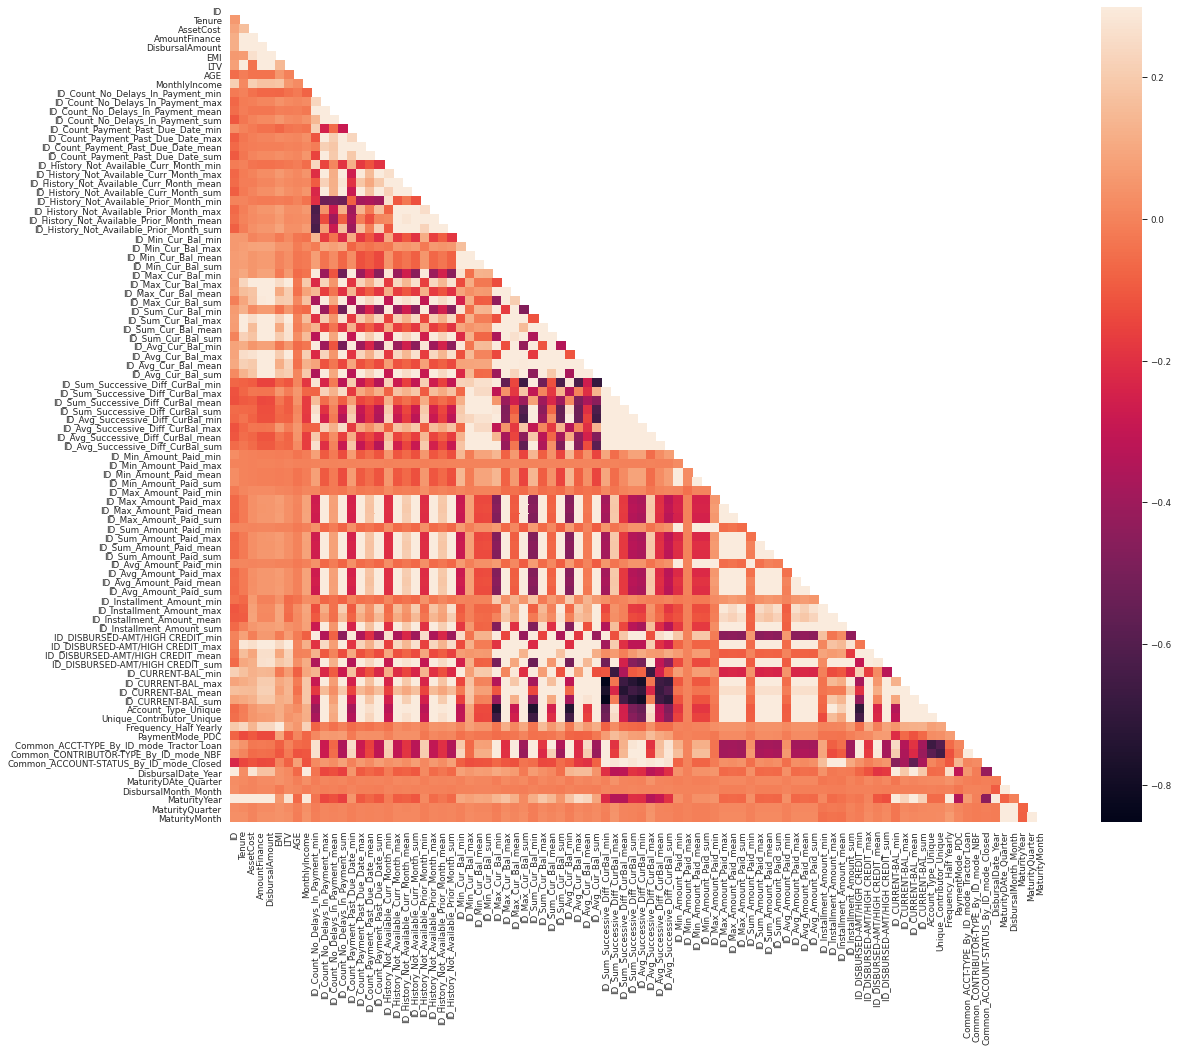

In [ ]:
#Plotting the heatmap
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20, 15))
    ax = sns.heatmap(corr_matrix, mask=mask, vmax=.3, square=True)

In [ ]:
#Custom function to compute features which are highly correlated. Remember, correlation doesn't imply causation.
def correlation(dataset, threshold):
  col_corr = set()
  corr_matrix = dataset.corr()
  for i in range(len(corr_matrix.columns)):
    for j in range(i):
      if (corr_matrix.iloc[i, j] > threshold):
        col_corr.add(corr_matrix.columns[i])
  return col_corr

In [ ]:
high_col_cors = set()
high_col_cors = list(correlation(df, 0.8))

In [ ]:
#Drop the highly correlated columns
df.drop(high_col_cors, axis=1, inplace=True)

In [ ]:
df.head()

,ID,Tenure,AssetCost,AmountFinance,EMI,LTV,AGE,MonthlyIncome,ID_Count_No_Delays_In_Payment_min,ID_Count_No_Delays_In_Payment_max,ID_Count_No_Delays_In_Payment_mean,ID_Count_No_Delays_In_Payment_sum,ID_Count_Payment_Past_Due_Date_min,ID_Count_Payment_Past_Due_Date_max,ID_Count_Payment_Past_Due_Date_mean,ID_History_Not_Available_Curr_Month_min,ID_History_Not_Available_Curr_Month_max,ID_History_Not_Available_Curr_Month_mean,ID_History_Not_Available_Prior_Month_min,ID_History_Not_Available_Prior_Month_max,ID_History_Not_Available_Prior_Month_mean,ID_History_Not_Available_Prior_Month_sum,ID_Min_Cur_Bal_min,ID_Min_Cur_Bal_max,ID_Min_Cur_Bal_mean,ID_Min_Cur_Bal_sum,ID_Max_Cur_Bal_min,ID_Max_Cur_Bal_max,ID_Max_Cur_Bal_mean,ID_Sum_Cur_Bal_min,ID_Sum_Successive_Diff_CurBal_min,ID_Sum_Successive_Diff_CurBal_max,ID_Sum_Successive_Diff_CurBal_mean,ID_Avg_Successive_Diff_CurBal_min,ID_Avg_Successive_Diff_CurBal_max,ID_Avg_Successive_Diff_CurBal_mean,ID_Min_Amount_Paid_min,ID_Min_Amount_Paid_max,ID_Max_Amount_Paid_min,ID_Max_Amount_Paid_max,ID_Max_Amount_Paid_mean,ID_Sum_Amount_Paid_min,ID_Sum_Amount_Paid_max,ID_Sum_Amount_Paid_mean,ID_Installment_Amount_min,ID_Installment_Amount_max,ID_Installment_Amount_mean,ID_DISBURSED-AMT/HIGH CREDIT_max,ID_CURRENT-BAL_min,ID_CURRENT-BAL_mean,Account_Type_Unique,Unique_Contributor_Unique,Frequency_Half Yearly,PaymentMode_PDC,Common_ACCT-TYPE_By_ID_mode_Tractor Loan,Common_CONTRIBUTOR-TYPE_By_ID_mode_NBF,Common_ACCOUNT-STATUS_By_ID_mode_Closed,DisbursalDate_Year,MaturityDAte_Quarter,DisbursalMonth_Month
0,1,48,450000,275000.0,24000.0,61.11,49.0,35833.33,1.0,36.0,12.555556,113.0,0.0,28.0,8.333333,0.0,1.0,0.333333,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,24650.0,502016.0,2.016129e+05,41950.0,-443769.0,0.0,-71464.000000,-3.169779e+04,0.0,-8793.789322,0,0,0,0,0.000000,0,0,0.000000e+00,1405.0,7934.0,4669.500000,500000.0,0.0,68725.111111,4,2,0,1,0,1,1,2012,1,2
1,2,47,485000,350000.0,10500.0,70.00,23.0,666.67,0.0,36.0,13.769231,179.0,0.0,31.0,2.384615,0.0,8.0,1.153846,0.0,5.0,0.461538,6.0,-3.0,0.0,-0.230769,-3.0,0.0,4666000.0,1.321513e+06,0.0,-4584553.0,0.0,-796112.076923,-1.528184e+06,0.0,-190914.068193,0,0,0,1100000,142630.769231,0,15400000,1.725608e+06,11430.0,74684.0,34852.600000,4666000.0,0.0,796112.076923,7,2,0,1,0,1,0,2012,1,3
2,3,68,690000,519728.0,38300.0,69.77,39.0,45257.00,0.0,15.0,1.935484,60.0,0.0,22.0,1.903226,0.0,4.0,0.387097,0.0,13.0,0.645161,20.0,0.0,0.0,0.000000,0.0,0.0,1125380.0,1.848856e+05,0.0,-811839.0,0.0,-75327.903226,-1.491365e+05,0.0,-9657.200201,0,0,0,461210,26274.903226,0,602035,4.285713e+04,815.0,27288.0,15906.000000,950000.0,0.0,66618.225806,8,5,0,0,0,0,1,2017,1,6
3,7,48,480000,400000.0,11600.0,80.92,24.0,20833.33,5.0,36.0,19.750000,79.0,0.0,0.0,0.000000,0.0,1.0,0.250000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,100000.0,780000.0,3.562168e+05,903546.0,-624000.0,0.0,-156000.000000,-4.160000e+04,0.0,-10400.000000,0,0,0,0,0.000000,0,0,0.000000e+00,5571.0,5571.0,5571.000000,542553.0,0.0,156000.000000,2,1,0,0,1,1,0,2013,4,11
4,8,44,619265,440000.0,15000.0,71.05,56.0,27313.67,0.0,36.0,12.285714,86.0,0.0,12.0,2.714286,0.0,6.0,1.142857,0.0,36.0,6.857143,48.0,-25000.0,0.0,-3571.428571,-25000.0,60400.0,875000.0,3.334960e+05,513400.0,-787500.0,0.0,-139159.857143,-7.875000e+04,0.0,-12457.932540,-4000,0,0,35520,8645.714286,0,142080,2.899000e+04,1865.0,4572.0,2912.666667,580000.0,0.0,139159.857143,3,3,0,0,1,1,0,2011,3,12


In [ ]:
#Oops one column is still left to be encoded
# disbursal_values={}
# for idx, value in enumerate(df['DisbursalDate_Month_End'].unique()):
#   disbursal_values[value] = idx

In [ ]:
#Label and drop the categorical column
# df['DisbursalDate_Month_End_Labelled'] = df['DisbursalDate_Month_End'].map(disbursal_values)
# df.drop(['DisbursalDate_Month_End'], axis=1, inplace=True)

In [ ]:
#Again splitting into train and test sets
df_train_1 = df[ : len(df_train)]
df_test_1 = df[len(df_train) : ] 
X = df_train_1
X_test = df_test_1

In [ ]:
#Train-Test split
X_train, X_valid, y_train, y_valid = train_test_split(X, Y_copy, test_size=0.3, random_state=seed_value, shuffle=True)

In [ ]:
#Printing the shape of train and validation sets
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(90058, 60)
(38597, 60)
(90058,)
(38597,)


In [ ]:
# df_train_1.drop(['Source'], axis=1, inplace=True)
# df_test_1.drop(['Source'], axis=1, inplace=True)

In [ ]:
#Replace all NaN values with 0 cause there are a lot may data for the model to learn and adapt
X_train.isna().sum()

ID                                               0
Tenure                                           0
AssetCost                                        0
AmountFinance                                    0
EMI                                              0
LTV                                              0
AGE                                              0
MonthlyIncome                                    0
ID_Count_No_Delays_In_Payment_min              816
ID_Count_No_Delays_In_Payment_max              816
ID_Count_No_Delays_In_Payment_mean             816
ID_Count_No_Delays_In_Payment_sum                0
ID_Count_Payment_Past_Due_Date_min             816
ID_Count_Payment_Past_Due_Date_max             816
ID_Count_Payment_Past_Due_Date_mean            816
ID_History_Not_Available_Curr_Month_min        816
ID_History_Not_Available_Curr_Month_max        816
ID_History_Not_Available_Curr_Month_mean       816
ID_History_Not_Available_Prior_Month_min       816
ID_History_Not_Available_Prior_

In [ ]:
#Further drop some columns and impute the rest of them
X_train.drop(['ID_Installment_Amount_min', 'ID_Installment_Amount_max', 'ID_Installment_Amount_mean'], axis=1, inplace=True)
X_test.drop(['ID_Installment_Amount_min', 'ID_Installment_Amount_max', 'ID_Installment_Amount_mean'], axis=1, inplace=True)

In [ ]:
#Dropping columns from X_valid as well
X_valid.drop(['ID_Installment_Amount_min', 'ID_Installment_Amount_max', 'ID_Installment_Amount_mean'], axis=1, inplace=True)

In [ ]:
X.drop(['ID'], axis=1, inplace=True)

In [ ]:
len(X_test.columns)

57

In [ ]:
#Impute rest of the columns with 0
X_train.fillna(0, axis=1, inplace=True)
X_valid.fillna(0, axis=1, inplace=True)
X_test.fillna(0, axis=1, inplace=True)

## **Modelling - (Hyperparameter Tuning + GridSearchCV + KFold)**

In [ ]:
#Initialising the classifiers
lr = LogisticRegression()
rmr = RandomForestClassifier()
adbr = AdaBoostClassifier()
xgbr = XGBRFClassifier()

In [ ]:
#Parameters for each of the models

#Logistic Regression Classifier
params_grid_lr = {
             "penalty" : ['l1', 'l2', 'elasticnet', 'none'],
             "C"       :  [0.001,0.01,0.1,1,10,100,1000],
             "fit_intercept" : [True, False],
             "solver" : ['newton-cg', 'sag', 'saga']
}

#Random Forest Regressor
params_grid_rmr = {
              "n_estimators" : [int(i) for i in np.linspace(100, 500, 10)],
              "min_samples_split": [10, 20, 40],
              "criterion" : ['gini', 'entropy'],
              "max_depth": [2, 6, 8],
              "min_samples_leaf": [20, 40, 100],
              "max_leaf_nodes": [5, 20, 100],
              "bootstrap" : [True, False],
              "max_features" : ['auto', 'sqrt', 'log2']
}

#XGBoost Regressor
params_grid_xgbr = {
             "learning_rate" : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40], 
             "max_depth" : [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 
             "min_child_weight" : [1, 3, 5, 7], 
             "gamma" : [0.0, 0.1, 0.2, 0.3, 0.4],
             "colsample_bytree" : [0.3, 0.5, 0.7], 
             "colsample_bylevel" : [0.2, 0.4, 0.6],
             "subsample" : [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
}

#AdaBoost Regressor
params_grid_adbr = {
            "learning_rate" : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40],
            "n_estimators" : [int(i) for i in np.linspace(100, 500, 10)], 
}

In [ ]:
#Using RandomizedSearch CV for training with cross validation, since its a very large dataset. Since its a large dataset, the labels will be preserved.
def fine_tune_params(classifier, parameters, X_train, y_train):
  rm = RandomizedSearchCV(estimator=classifier, param_distributions=parameters, n_iter=8, n_jobs=-1, cv=9, random_state=seed_value)
  search = rm.fit(X_train, y_train)
  bs = search.best_score_
  bp = search.best_params_
  return bs, bp

**Logistic Regression**

In [ ]:
acc_scores, roc_auc_scores = [], []

In [ ]:
#Logistic Regression Classifier
#bs_logistic, bp_logistic = fine_tune_params(lr, params_grid_lr, X_train, y_train)
##Grid SearchCV or Randomized SearchCV taking too long to respond, Hence we will handpick some parameters as mentioned in parameter grid
lr = LogisticRegression(fit_intercept=True, solver='saga', random_state=seed_value, C=0.01)
lr.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=15042, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
#Classification metric evaluations
pred_lr = lr.predict(X_valid)
print(accuracy_score(y_valid, pred_lr))
acc_scores.append(accuracy_score(y_valid, pred_lr))

print(confusion_matrix(y_valid, pred_lr))
print(classification_report(y_valid, pred_lr))

0.8289504365624272
[[31995     1     0     8     0     0     0]
 [  305     0     0     0     0     0     0]
 [ 1053     0     0     0     0     0     0]
 [ 2477     0     0     0     0     1     0]
 [  929     0     0     0     0     0     0]
 [  773     0     0     1     0     0     0]
 [ 1054     0     0     0     0     0     0]]
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     32004
           1       0.00      0.00      0.00       305
           2       0.00      0.00      0.00      1053
           3       0.00      0.00      0.00      2478
           4       0.00      0.00      0.00       929
           5       0.00      0.00      0.00       774
           6       0.00      0.00      0.00      1054

    accuracy                           0.83     38597
   macro avg       0.12      0.14      0.13     38597
weighted avg       0.69      0.83      0.75     38597



In [ ]:
# y_true = np.argmax(y_valid, axis=0)
# y_valid.values
# y_valid = y_valid.reshape(y_valid)
# pred_lr_proba = lr.predict_proba(X_valid)

# # roc curve for classes
# fpr = {}
# tpr = {}
# thresh ={}
# roc_auc_score(y_valid, pred_lr_proba, multi_class='ovr')

**Random Forest Classifier**

In [ ]:
rmr = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=20, 
                             min_samples_leaf=20, bootstrap=True,
                             random_state=seed_value)
rmr.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=15042,
                       verbose=0, warm_start=False)

In [ ]:
#Classification metric evaluations
pred_rmr = rmr.predict(X_valid)
print(accuracy_score(y_valid, pred_rmr))
acc_scores.append(accuracy_score(y_valid, pred_rmr))
acc_scores.append(accuracy_score(y_valid, pred_rmr))

print(confusion_matrix(y_valid, pred_rmr))
print(classification_report(y_valid, pred_rmr))

0.8306604140218151
[[31982     0     0    22     0     0     0]
 [  304     0     0     1     0     0     0]
 [ 1053     0     0     0     0     0     0]
 [ 2399     0     0    79     0     0     0]
 [  927     0     0     2     0     0     0]
 [  773     0     0     1     0     0     0]
 [ 1054     0     0     0     0     0     0]]
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     32004
           1       0.00      0.00      0.00       305
           2       0.00      0.00      0.00      1053
           3       0.75      0.03      0.06      2478
           4       0.00      0.00      0.00       929
           5       0.00      0.00      0.00       774
           6       0.00      0.00      0.00      1054

    accuracy                           0.83     38597
   macro avg       0.23      0.15      0.14     38597
weighted avg       0.74      0.83      0.76     38597



**XGBoost Classifier**

In [ ]:
#XGBR Classifier
xgbr = XGBRFClassifier(learning_rate=0.01, min_child_weight=5, max_depth=10, 
                       gamma=0.05, colsample_bytree=0.6, colsample_bylevel=0.6,
                       subsample=0.9)
xgbr.fit(X_train, y_train)

XGBRFClassifier(base_score=0.5, colsample_bylevel=0.6, colsample_bynode=0.8,
                colsample_bytree=0.6, gamma=0.05, learning_rate=0.01,
                max_delta_step=0, max_depth=10, min_child_weight=5,
                missing=None, n_estimators=100, n_jobs=1, nthread=None,
                objective='multi:softprob', random_state=0, reg_alpha=0,
                reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
                subsample=0.9, verbosity=1)

In [ ]:
#Classification metric evaluations
pred_xgbr = xgbr.predict(X_valid)
print(accuracy_score(y_valid, pred_xgbr))
acc_scores.append(accuracy_score(y_valid, pred_xgbr))

print(confusion_matrix(y_valid, pred_xgbr))
print(classification_report(y_valid, pred_xgbr))

0.8311526802601238
[[31985     0     0    19     0     0     0]
 [  304     0     0     1     0     0     0]
 [ 1050     0     2     1     0     0     0]
 [ 2385     0     0    93     0     0     0]
 [  926     0     0     3     0     0     0]
 [  773     0     0     1     0     0     0]
 [ 1053     0     0     1     0     0     0]]
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     32004
           1       0.00      0.00      0.00       305
           2       1.00      0.00      0.00      1053
           3       0.78      0.04      0.07      2478
           4       0.00      0.00      0.00       929
           5       0.00      0.00      0.00       774
           6       0.00      0.00      0.00      1054

    accuracy                           0.83     38597
   macro avg       0.37      0.15      0.14     38597
weighted avg       0.77      0.83      0.76     38597



**LGBMClassifier + Stratified K-Fold(since its an imbalanced dataset)**

In [ ]:
len(X.columns)

59

In [ ]:
X.drop(['ID_Installment_Amount_min', 'ID_Installment_Amount_max', 'ID_Installment_Amount_mean'], axis=1, inplace=True)

In [ ]:
#Stratified K-Fold Cross Validation
#kf = StratifiedKFold(n_splits=10, random_state=seed_value, shuffle=True)

# for train_index,test_index in kf.split(X,y):
#      print('\n{} of kfold {}'.format(i,kf.n_splits))
#      xtr,xvl = X.loc[train_index],X.loc[test_index]
#      ytr,yvl = y[train_index],y[test_index]
#      model = GridSearchCV(XGBClassifier(), param_grid, cv=10, scoring= 'f1', iid=True)
#      model.fit(xtr, ytr)
#      print (model.best_params_)
#      pred=model.predict(xvl)
#      print('accuracy_score',accuracy_score(yvl,pred))
#      i+=1

In [ ]:
X.shape

(128655, 56)

In [ ]:
#Creating a copy of X as well
X_copy = X.copy()

In [ ]:
#Dropping columns yet again, will perform discretization sometime later
cols_to_drop = []
for col in X_copy.columns:
   if X_copy[col].nunique() < 30:
      cols_to_drop.append(col)

In [ ]:
X_copy.drop(cols_to_drop, axis=1, inplace=True)

In [ ]:
X_test.drop(cols_to_drop, axis=1, inplace=True)

In [ ]:
len(X_test.columns)

44

In [ ]:
X_test.drop(['ID'], axis=1, inplace=True)

In [ ]:
# Modelling with Stratified K Fold cross validation, there is surely some issue with the final predictions
f1 = []
final_preds = []
folds = StratifiedKFold(n_splits=5)
for train_index, test_index in folds.split(X_copy, Y_copy.values):

    # creating training and validation datasets
    X_Train, X_Test = X_copy.iloc[train_index], X_copy.iloc[test_index]
    y_Train, y_Test = Y_copy.iloc[train_index], Y_copy.iloc[test_index]
    
    # building a classifier
    clf = LGBMClassifier(n_estimators=750,
                             learning_rate=0.1,
                             objective="multiclass",
                             boosting_type="gbdt",
                             subsample=0.9,
                             colsample_bytree=0.6,
                             num_class=7,
                             max_depth=12,
                             n_jobs=-1,
                             reg_alpha=2,
                             num_leaves=100,
                             class_weight='balanced')
    
    # fitting the classifier to the train set
    clf.fit(X_Train,
            y_Train,
            eval_set=[(X_Train, y_Train),(X_Test, y_Test)],
            early_stopping_rounds=50,
            verbose=50)
    
    # predicting on the validation set
    preds = clf.predict(X_Test)
    score = f1_score(preds, y_Test, average='macro')
    print ("F1 Score:",score)
    print ("------------------------------------------------")
    f1.append(score)
    
    # Predicting on the test set, final_preds will be an array of 5 sets of predictions, one for each fold
    pred = clf.predict(X_test, num_iteration=None)
    final_preds.append(pred)
    
print ("------------------------------------------")
print ("Mean F1 Score of 5 Folds:", np.mean(np.array(f1)))

Training until validation scores don't improve for 50 rounds.
[50]	training's multi_logloss: 1.09944	valid_1's multi_logloss: 1.38706
[100]	training's multi_logloss: 0.815307	valid_1's multi_logloss: 1.23278
[150]	training's multi_logloss: 0.639347	valid_1's multi_logloss: 1.13424
[200]	training's multi_logloss: 0.514791	valid_1's multi_logloss: 1.04886
[250]	training's multi_logloss: 0.424723	valid_1's multi_logloss: 0.983918
[300]	training's multi_logloss: 0.355213	valid_1's multi_logloss: 0.935223
[350]	training's multi_logloss: 0.300766	valid_1's multi_logloss: 0.893167
[400]	training's multi_logloss: 0.258924	valid_1's multi_logloss: 0.857327
[450]	training's multi_logloss: 0.225066	valid_1's multi_logloss: 0.827593
[500]	training's multi_logloss: 0.198239	valid_1's multi_logloss: 0.803392
[550]	training's multi_logloss: 0.176108	valid_1's multi_logloss: 0.783324
[600]	training's multi_logloss: 0.158059	valid_1's multi_logloss: 0.767304
[650]	training's multi_logloss: 0.142703	val

**Test Dataset Predictions**

In [ ]:
y_valid.values

array([0, 0, 0, ..., 0, 4, 0])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 <a list of 44 Text major ticklabel objects>)

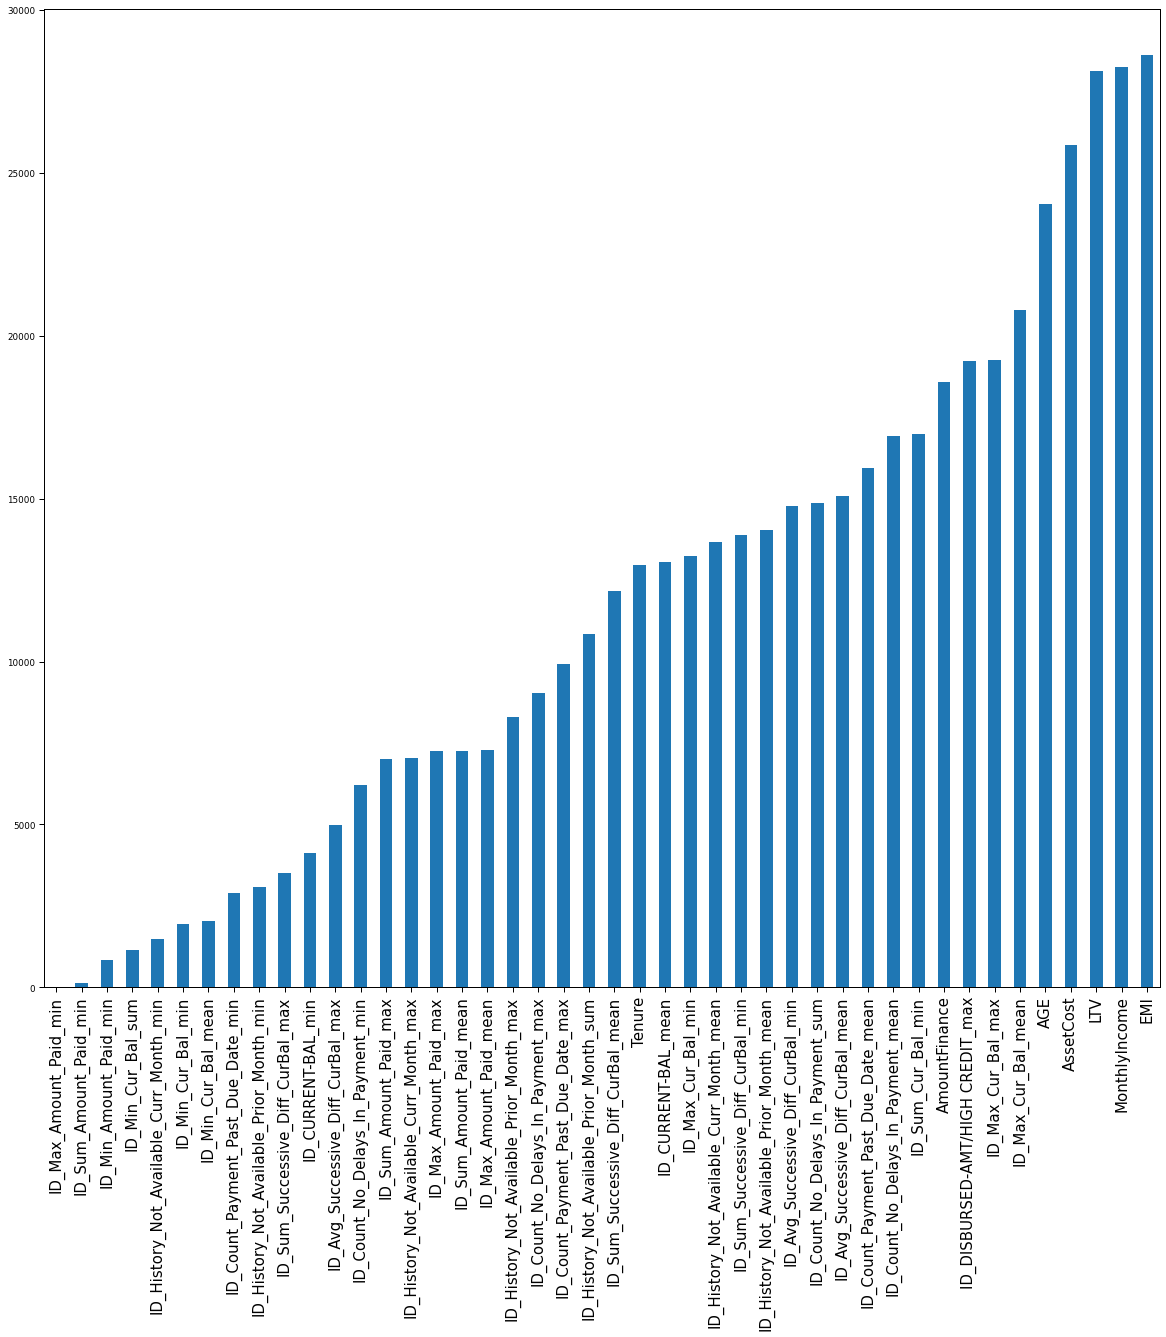

In [ ]:
ser = pd.Series(clf.feature_importances_, X_copy.columns).sort_values()
ax = ser.plot(kind='bar', figsize=(20, 18))
plt.xticks(size=15)

**Dumping models to file**

In [ ]:
%cd /content/drive/MyDrive/Datasets/Finance/saved models

/content/drive/MyDrive/Datasets/Finance/saved models


In [ ]:
#Saving Random Forest Classifier
file_rmr = 'rmr.sav '
joblib.dump(rmr, file_rmr)

['rmr.sav ']

In [ ]:
#Saving XGBoost classifier
file_xgbr = 'xgbr.sav'
joblib.dump(xgbr, file_xgbr)

['xgbr.sav']

In [ ]:
#Saving LGBM classifier
file_lgbm = 'lgbm.sav'
joblib.dump(clf, file_lgbm)

['lgbm.sav']